# SVD-Only Clustering Analysis

This notebook performs clustering analysis on H&M articles using **only** SVD-reduced TF-IDF vectors (excluding categorical features). It utilises the `ArticleClusterer` module to:

1. Load SVD features from the combined article features file
2. Perform K-means clustering with optimal k selection
3. Visualise clusters using PCA and t-SNE
4. Interpret cluster characteristics

## Setup and Imports


In [1]:
import sys
import os
import warnings
sys.path.append('../')  # Add project root to path

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

# Import our clustering module
from hnm_data_analysis.clustering.article_clustering import (
    ArticleClusterer, 
    ClusteringConfig, 
    ClusteringResults
)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

warnings.filterwarnings('ignore')

## Data Loading

Load only the SVD-reduced TF-IDF vectors from the combined article features file.


In [2]:
# Define file paths
features_path = r"C:\Users\tom\coding_projects\data_analytics_projects\h_and_m_data_analysis\data\features\combined_article_features.parquet"
articles_metadata_path = r"C:\Users\tom\coding_projects\data_analytics_projects\h_and_m_data_analysis\data\processed\articles_last_3_months.parquet"

# Check if files exist
print(f"Combined features file exists: {os.path.exists(features_path)}")
print(f"Articles metadata file exists: {os.path.exists(articles_metadata_path)}")

print("\nNote: Using SVD features only (categorical features excluded)")

Combined features file exists: True
Articles metadata file exists: True

Note: Using SVD features only (categorical features excluded)


In [3]:
# Read and filter to SVD features only
print("Loading and filtering to SVD features only...")
features_df = pl.read_parquet(features_path)

# Identify SVD features
svd_cols = [c for c in features_df.columns if c.startswith('svd_')]
categorical_cols = [c for c in features_df.columns if not c.startswith('svd_') and c != 'article_id']

print(f"Total columns in file: {len(features_df.columns)}")
print(f"SVD features: {len(svd_cols)} (using these for clustering)")
print(f"Categorical features: {len(categorical_cols)} (excluded from clustering)")

# Create SVD-only dataset
svd_features_df = features_df.select(['article_id'] + sorted(svd_cols))
print(f"\nSVD-only dataset shape: {svd_features_df.shape}")

# Save temporary SVD-only file
temp_svd_path = "../data/temp/svd_only_features.parquet"
os.makedirs("../data/temp", exist_ok=True)
svd_features_df.write_parquet(temp_svd_path)
print(f"Saved SVD-only features to: {temp_svd_path}")

Loading and filtering to SVD features only...
Total columns in file: 225
SVD features: 200 (using these for clustering)
Categorical features: 24 (excluded from clustering)

SVD-only dataset shape: (42229, 201)
Saved SVD-only features to: ../data/temp/svd_only_features.parquet


In [4]:
# Initialise the clusterer with SVD-only features
clusterer = ArticleClusterer(
    features_path=temp_svd_path,
    articles_metadata_path=articles_metadata_path
)

print("Article Clusterer initialised with SVD-only features!")

Article Clusterer initialised with SVD-only features!


In [5]:
# Load the SVD feature data
features, article_ids = clusterer.load_features()
print(f"\nLoaded features shape: {features.shape}")
print(f"Number of articles: {len(article_ids):,}")
print(f"SVD dimensions: {features.shape[1]:,}")

# Display basic feature statistics
print(f"\nSVD Feature Statistics:")
print(f"Mean: {features.mean():.4f}")
print(f"Std: {features.std():.4f}")
print(f"Min: {features.min():.4f}")
print(f"Max: {features.max():.4f}")

Loaded features: 42,229 articles x 200 features

Loaded features shape: (42229, 200)
Number of articles: 42,229
SVD dimensions: 200

SVD Feature Statistics:
Mean: 0.0000
Std: 1.0000
Min: -6.7909
Max: 9.0768


In [6]:
# Load articles metadata for cluster interpretation
metadata = clusterer.load_articles_metadata()

if metadata is not None:
    print(f"\nMetadata shape: {metadata.shape}")
    print("Available columns for cluster interpretation:")
    for col in metadata.columns:
        print(f"  - {col}")
else:
    print("\nMetadata not available for cluster interpretation")

Loaded articles metadata: 42,298 articles

Metadata shape: (42298, 25)
Available columns for cluster interpretation:
  - article_id
  - product_code
  - prod_name
  - product_type_no
  - product_type_name
  - product_group_name
  - graphical_appearance_no
  - graphical_appearance_name
  - colour_group_code
  - colour_group_name
  - perceived_colour_value_id
  - perceived_colour_value_name
  - perceived_colour_master_id
  - perceived_colour_master_name
  - department_no
  - department_name
  - index_code
  - index_name
  - index_group_no
  - index_group_name
  - section_no
  - section_name
  - garment_group_no
  - garment_group_name
  - detail_desc


## SVD Feature Analysis

Examine the SVD-reduced TF-IDF vectors to understand their characteristics.


SVD Features Analysis:
Total SVD components: 200
SVD component range: svd_001 to svd_200


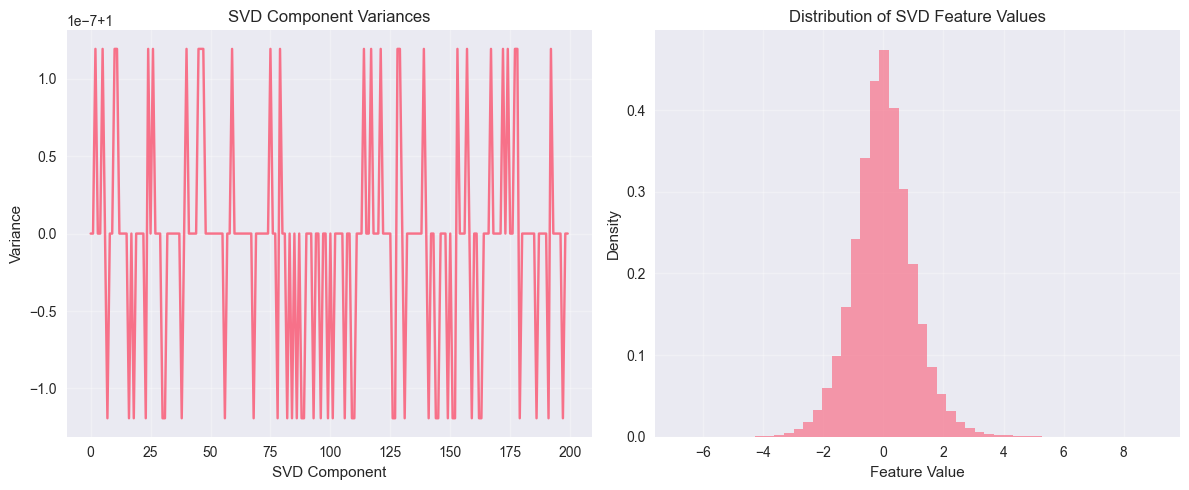


Top 10 SVD components by variance:
  1. SVD component 47: variance = 1.0000
  2. SVD component 79: variance = 1.0000
  3. SVD component 177: variance = 1.0000
  4. SVD component 117: variance = 1.0000
  5. SVD component 24: variance = 1.0000
  6. SVD component 174: variance = 1.0000
  7. SVD component 172: variance = 1.0000
  8. SVD component 75: variance = 1.0000
  9. SVD component 121: variance = 1.0000
  10. SVD component 167: variance = 1.0000


In [7]:
# Analyse SVD feature distribution
print(f"SVD Features Analysis:")
print(f"Total SVD components: {len(svd_cols)}")
print(f"SVD component range: {min(svd_cols)} to {max(svd_cols)}")

# Plot SVD feature variance
feature_variances = np.var(features, axis=0)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(feature_variances)
plt.title('SVD Component Variances')
plt.xlabel('SVD Component')
plt.ylabel('Variance')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(features.flatten(), bins=50, alpha=0.7, density=True)
plt.title('Distribution of SVD Feature Values')
plt.xlabel('Feature Value')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTop 10 SVD components by variance:")
top_variance_indices = np.argsort(feature_variances)[-10:][::-1]
for i, idx in enumerate(top_variance_indices):
    print(f"  {i+1}. SVD component {idx}: variance = {feature_variances[idx]:.4f}")

## Optimal K Selection

Find the optimal number of clusters using both elbow method and silhouette analysis on SVD features.


In [8]:
# Find optimal k using elbow method
print("Finding optimal k using elbow method...")
optimal_k_elbow, elbow_scores = clusterer.find_optimal_k(
    k_range=(2, 15), 
    algorithm="kmeans", 
    method="elbow"
)

print(f"\nOptimal k (elbow method): {optimal_k_elbow}")

Finding optimal k using elbow method...
Finding optimal k using elbow method with kmeans...
k=2: elbow score = 8381623.0000
k=3: elbow score = 8337832.0000
k=4: elbow score = 8292382.5000
k=5: elbow score = 8253734.0000
k=6: elbow score = 8218486.5000
k=7: elbow score = 8188124.0000
k=8: elbow score = 8135543.5000
k=9: elbow score = 8110728.5000
k=10: elbow score = 8073788.5000
k=11: elbow score = 8044225.5000
k=12: elbow score = 7973252.0000
k=13: elbow score = 7946810.0000
k=14: elbow score = 7913834.5000
k=15: elbow score = 7882591.0000
Optimal k selected: 12

Optimal k (elbow method): 12


In [9]:
# Find optimal k using silhouette analysis
print("Finding optimal k using silhouette analysis...")
optimal_k_silhouette, silhouette_scores = clusterer.find_optimal_k(
    k_range=(2, 15), 
    algorithm="kmeans", 
    method="silhouette"
)

print(f"\nOptimal k (silhouette method): {optimal_k_silhouette}")

Finding optimal k using silhouette analysis...
Finding optimal k using silhouette method with kmeans...
k=2: silhouette score = 0.0203
k=3: silhouette score = 0.0122
k=4: silhouette score = 0.0091
k=5: silhouette score = -0.0016
k=6: silhouette score = 0.0071
k=7: silhouette score = -0.0122
k=8: silhouette score = -0.0006
k=9: silhouette score = 0.0005
k=10: silhouette score = -0.0191
k=11: silhouette score = 0.0123
k=12: silhouette score = -0.0054
k=13: silhouette score = 0.0083
k=14: silhouette score = 0.0013
k=15: silhouette score = -0.0080
Optimal k selected: 2

Optimal k (silhouette method): 2


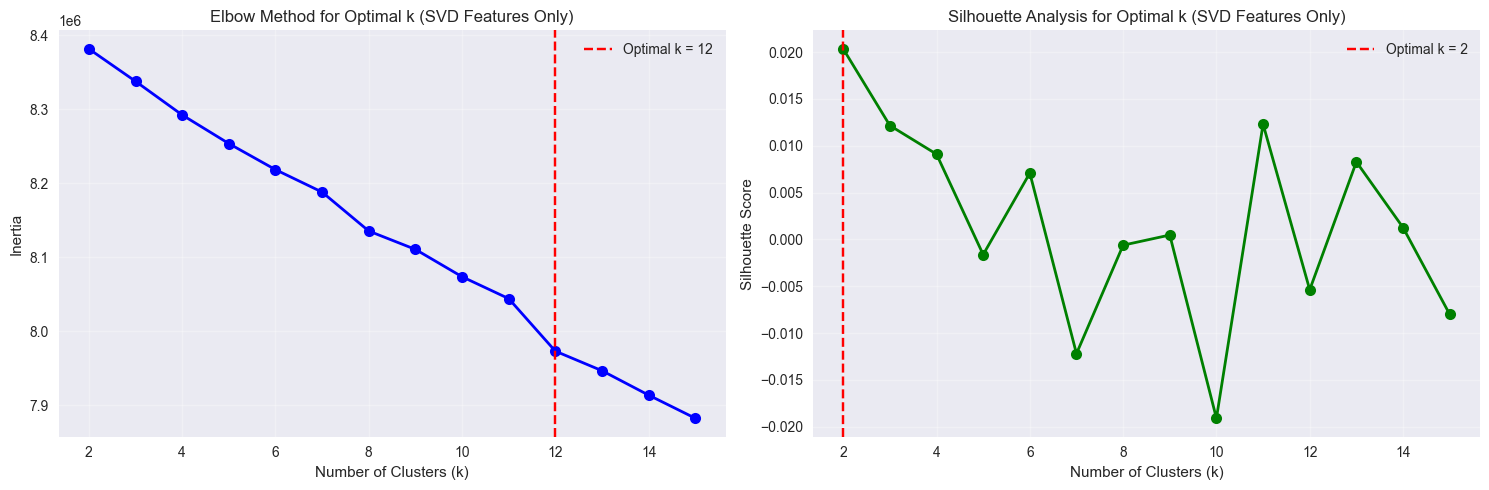


Selected k = 2 for final SVD-based clustering


In [10]:
# Plot k selection curves for SVD features
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow plot
k_values = sorted(elbow_scores.keys())
inertia_values = [elbow_scores[k] for k in k_values]
ax1.plot(k_values, inertia_values, 'bo-', linewidth=2, markersize=8)
ax1.axvline(x=optimal_k_elbow, color='red', linestyle='--', 
           label=f'Optimal k = {optimal_k_elbow}')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k (SVD Features Only)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Silhouette plot
silhouette_values = [silhouette_scores[k] for k in k_values]
ax2.plot(k_values, silhouette_values, 'go-', linewidth=2, markersize=8)
ax2.axvline(x=optimal_k_silhouette, color='red', linestyle='--', 
           label=f'Optimal k = {optimal_k_silhouette}')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis for Optimal k (SVD Features Only)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Choose final k (prefer silhouette method)
final_k = optimal_k_silhouette
print(f"\nSelected k = {final_k} for final SVD-based clustering")

## K-means Clustering on SVD Features

Perform K-means clustering using only the SVD-reduced TF-IDF vectors.


In [11]:
# Configure clustering
config = ClusteringConfig(
    algorithm="kmeans",
    n_clusters=final_k,
    random_state=42,
    kmeans_n_init=20  # More initialisations for better results
)

# Perform clustering
print(f"Performing K-means clustering on SVD features with k = {final_k}...")
results = clusterer.cluster(config)

print(f"\nSVD-Based Clustering Results:")
print(f"Algorithm: {results.algorithm}")
print(f"Number of clusters: {results.n_clusters}")
print(f"Feature dimensions: {results.feature_shape[1]} (SVD components only)")
print(f"Silhouette score: {results.silhouette:.4f}")
print(f"Calinski-Harabasz index: {results.calinski_harabasz:.2f}")
print(f"Davies-Bouldin index: {results.davies_bouldin:.4f}")

Performing K-means clustering on SVD features with k = 2...
Performing kmeans clustering...
Clustering completed: 2 clusters
Silhouette Score: 0.0203
Calinski-Harabasz Index: 323.3158
Davies-Bouldin Index: 9.9936

SVD-Based Clustering Results:
Algorithm: kmeans
Number of clusters: 2
Feature dimensions: 200 (SVD components only)
Silhouette score: 0.0203
Calinski-Harabasz index: 323.32
Davies-Bouldin index: 9.9936


Cluster size distribution (SVD-based):
Cluster 0: 31,428 articles (74.4%)
Cluster 1: 10,801 articles (25.6%)


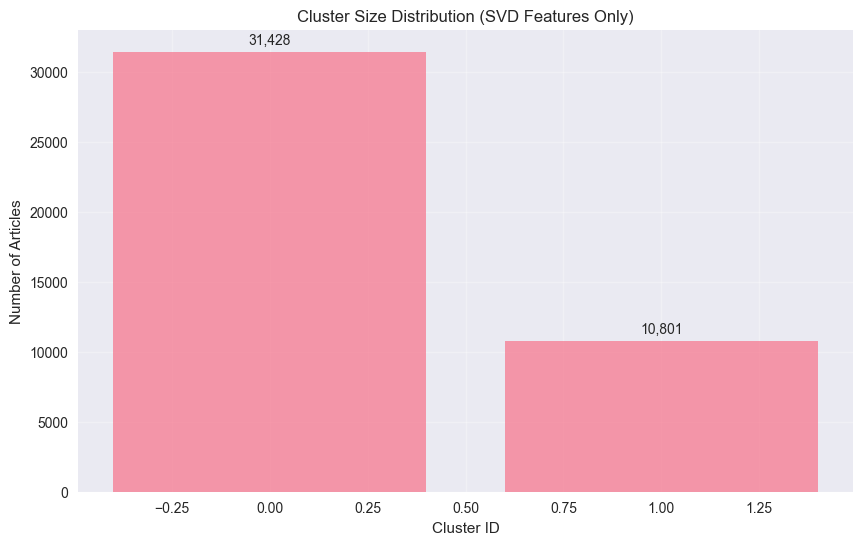

In [12]:
# Analyse cluster sizes
unique_labels, counts = np.unique(results.labels, return_counts=True)
cluster_sizes = dict(zip(unique_labels, counts))

print("Cluster size distribution (SVD-based):")
for cluster_id in sorted(cluster_sizes.keys()):
    size = cluster_sizes[cluster_id]
    percentage = (size / len(results.labels)) * 100
    print(f"Cluster {cluster_id}: {size:,} articles ({percentage:.1f}%)")

# Plot cluster size distribution
plt.figure(figsize=(10, 6))
clusters = sorted(cluster_sizes.keys())
sizes = [cluster_sizes[c] for c in clusters]
bars = plt.bar(clusters, sizes, alpha=0.7)
plt.xlabel('Cluster ID')
plt.ylabel('Number of Articles')
plt.title('Cluster Size Distribution (SVD Features Only)')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, size in zip(bars, sizes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(sizes)*0.01, 
             f'{size:,}', ha='center', va='bottom')

plt.show()

## Cluster Visualization

Visualise the SVD-based clusters using both PCA and t-SNE dimensionality reduction.


Creating PCA visualisation of SVD-based clusters...
Creating 2D visualization using PCA...


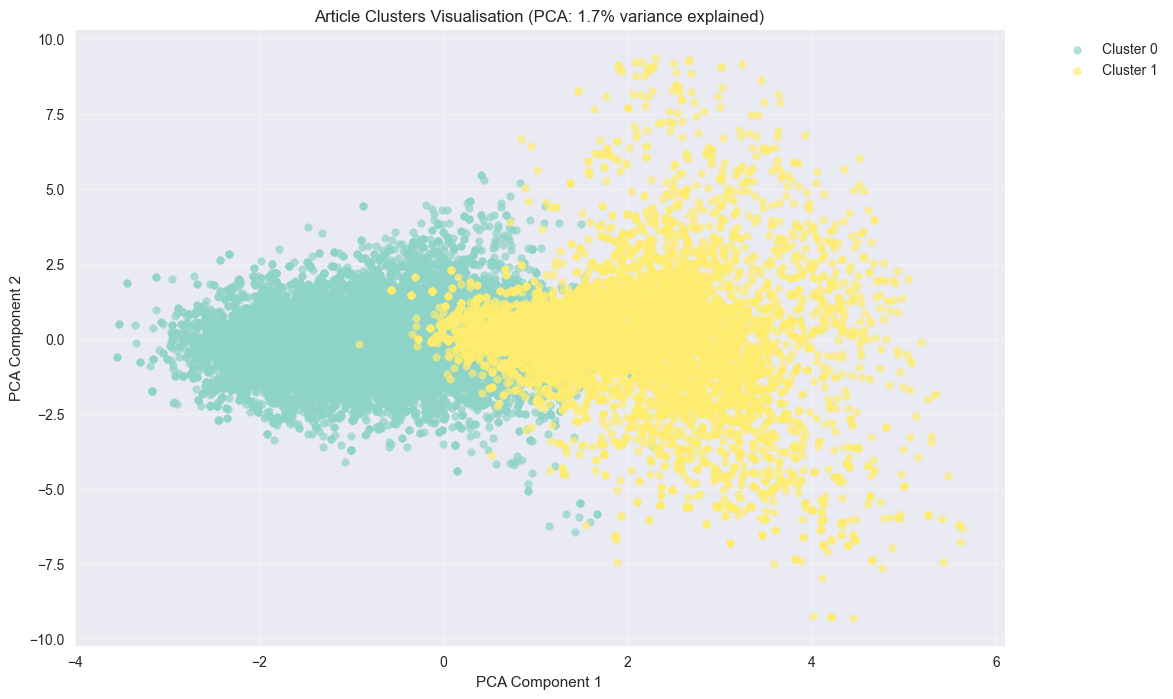

In [13]:
# PCA visualization of SVD-based clusters
print("Creating PCA visualisation of SVD-based clusters...")
clusterer.visualise_clusters(method="pca")

Creating t-SNE visualisation of SVD-based clusters...
Note: t-SNE may take several minutes for large datasets
Creating 2D visualization using TSNE...


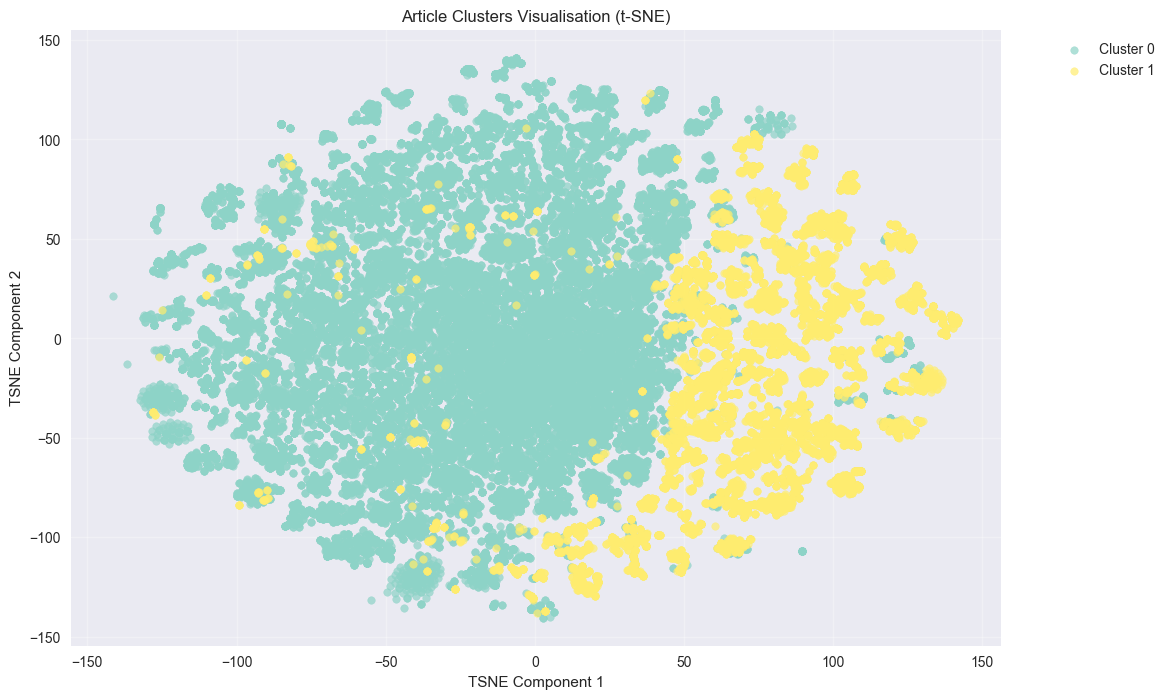

In [14]:
# t-SNE visualization (this may take a while for large datasets)
print("Creating t-SNE visualisation of SVD-based clusters...")
print("Note: t-SNE may take several minutes for large datasets")
clusterer.visualise_clusters(method="tsne")

## Cluster Interpretation

Analyse SVD-based cluster characteristics using the article metadata.


In [15]:
# Interpret SVD-based clusters
print("Interpreting SVD-based clusters...")
cluster_summaries = clusterer.interpret_clusters(top_features=10)

# Display cluster summaries
for cluster_id in sorted(cluster_summaries.keys()):
    summary = cluster_summaries[cluster_id]
    print(f"\n{'='*60}")
    print(f"SVD-BASED CLUSTER {cluster_id}")
    print(f"{'='*60}")
    print(f"Size: {summary['size']:,} articles ({summary['percentage']:.1f}%)")
    
    # Show top categories for each cluster
    categorical_fields = [
        'top_product_group_name', 'top_product_type_name', 
        'top_colour_group_name', 'top_department_name', 'top_garment_group_name'
    ]
    
    for field in categorical_fields:
        if field in summary and summary[field]:
            field_name = field.replace('top_', '').replace('_', ' ').title()
            print(f"\n{field_name}:")
            for category, count in list(summary[field].items())[:3]:  # Top 3
                print(f"  {category}: {count} articles")
    
    # Show sample article IDs
    print(f"\nSample Article IDs: {summary['article_ids'][:5]}")
    
    print(f"\nNote: Clusters based purely on text similarity (SVD of TF-IDF vectors)")

Interpreting SVD-based clusters...

SVD-BASED CLUSTER 0
Size: 31,428 articles (74.4%)

Product Group Name:
  product_group_name: shape: (5,)
Series: 'product_group_name' [str]
[
	"Socks & Tights"
	"Unknown"
	"Garment and Shoe care"
	"Items"
	"Garment Upper body"
] articles
  count: shape: (5,)
Series: 'count' [u32]
[
	784
	53
	2
	4
	14909
] articles

Product Type Name:
  product_type_name: shape: (5,)
Series: 'product_type_name' [str]
[
	"Leg warmers"
	"Gloves"
	"Trousers"
	"Scarf"
	"Long John"
] articles
  count: shape: (5,)
Series: 'count' [u32]
[
	1
	59
	4635
	27
	11
] articles

Colour Group Name:
  colour_group_name: shape: (5,)
Series: 'colour_group_name' [str]
[
	"Turquoise"
	"Light Blue"
	"Bronze/Copper"
	"Light Turquoise"
	"Silver"
] articles
  count: shape: (5,)
Series: 'count' [u32]
[
	98
	1117
	2
	240
	19
] articles

Department Name:
  department_name: shape: (5,)
Series: 'department_name' [str]
[
	"Young Girl S&T"
	"Dress"
	"Baby Girl Knitwear"
	"Jersey inactive from s1"
	"

## SVD Feature Importance Analysis

Analyse which SVD components are most important for distinguishing between clusters.


Top 20 Most Important SVD Components for Clustering:
   1. SVD component   0: importance = 1.7387
   2. SVD component   4: importance = 1.1103
   3. SVD component   8: importance = 0.8194
   4. SVD component   9: importance = 0.6244
   5. SVD component  12: importance = 0.5543
   6. SVD component  10: importance = 0.4298
   7. SVD component   3: importance = 0.4111
   8. SVD component   2: importance = 0.3834
   9. SVD component   5: importance = 0.3770
  10. SVD component  15: importance = 0.3634
  11. SVD component  17: importance = 0.3243
  12. SVD component  16: importance = 0.3026
  13. SVD component  18: importance = 0.2976
  14. SVD component  14: importance = 0.2837
  15. SVD component  11: importance = 0.2757
  16. SVD component   6: importance = 0.2643
  17. SVD component   7: importance = 0.2552
  18. SVD component  48: importance = 0.2300
  19. SVD component  61: importance = 0.2120
  20. SVD component  53: importance = 0.2043


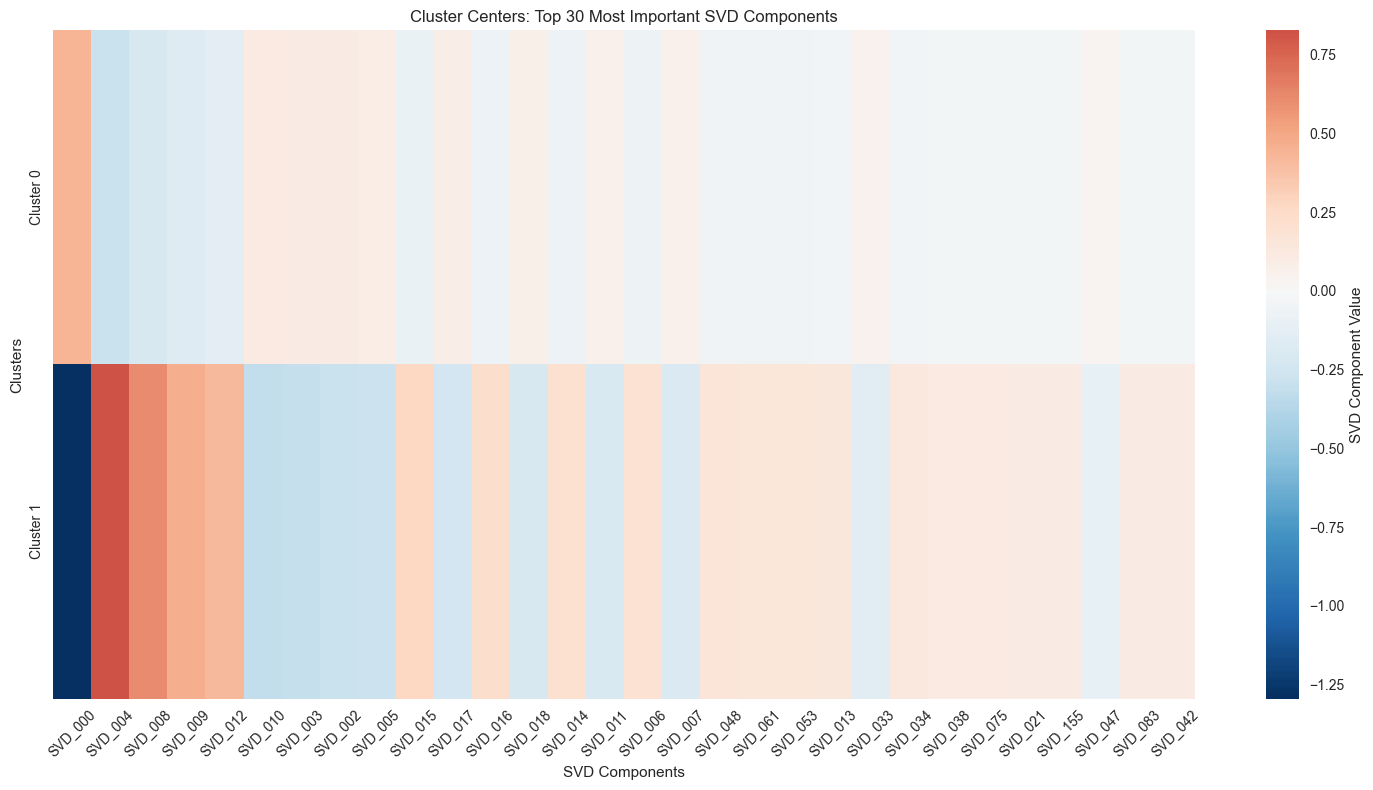


Cluster centers shape: (2, 200)
All 200 SVD components used in clustering


In [16]:
# Analyse SVD feature importance in clusters
if hasattr(clusterer.clustering_model, 'cluster_centers_'):
    cluster_centers = clusterer.clustering_model.cluster_centers_
    
    # Calculate feature importance as the range across cluster centers
    feature_importance = np.ptp(cluster_centers, axis=0)  # peak-to-peak (max - min)
    
    # Get top important SVD components
    top_features_idx = np.argsort(feature_importance)[-20:][::-1]  # Top 20
    
    print(f"Top 20 Most Important SVD Components for Clustering:")
    for i, idx in enumerate(top_features_idx):
        print(f"  {i+1:2d}. SVD component {idx:3d}: importance = {feature_importance[idx]:.4f}")
    
    # Plot heatmap of cluster centers for top features
    plt.figure(figsize=(15, 8))
    
    # Use top 30 features for visualization
    top_30_idx = np.argsort(feature_importance)[-30:][::-1]
    centers_important = cluster_centers[:, top_30_idx]
    feature_labels = [f'SVD_{i:03d}' for i in top_30_idx]
    
    sns.heatmap(centers_important, 
                xticklabels=feature_labels,
                yticklabels=[f'Cluster {i}' for i in range(cluster_centers.shape[0])],
                cmap='RdBu_r', center=0, cbar_kws={'label': 'SVD Component Value'})
    plt.title('Cluster Centers: Top 30 Most Important SVD Components')
    plt.xlabel('SVD Components')
    plt.ylabel('Clusters')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(f"\nCluster centers shape: {cluster_centers.shape}")
    print(f"All {cluster_centers.shape[1]} SVD components used in clustering")

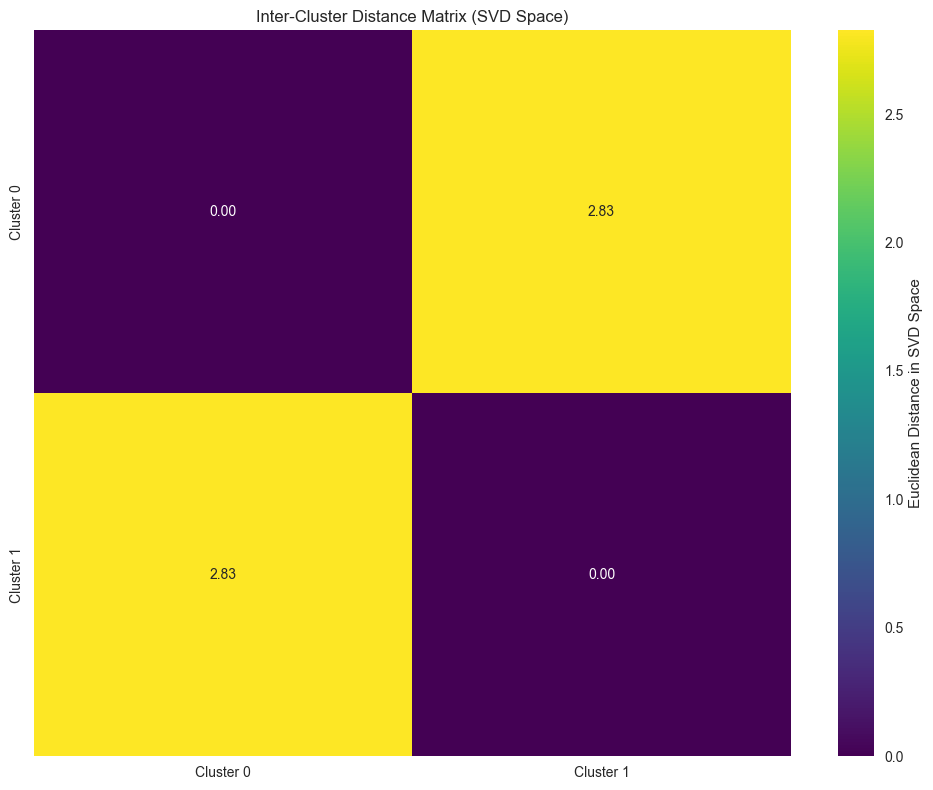


Most similar clusters in SVD space: 0 and 1 (distance: 2.83)
Most different clusters in SVD space: 0 and 0 (distance: inf)

Note: Distances computed in 200-dimensional SVD space


In [17]:
# Calculate inter-cluster distances in SVD space
if hasattr(clusterer.clustering_model, 'cluster_centers_'):
    from scipy.spatial.distance import pdist, squareform
    
    # Calculate pairwise distances between cluster centers in SVD space
    distances = pdist(cluster_centers, metric='euclidean')
    distance_matrix = squareform(distances)
    
    # Plot distance matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(distance_matrix,
                xticklabels=[f'Cluster {i}' for i in range(len(cluster_centers))],
                yticklabels=[f'Cluster {i}' for i in range(len(cluster_centers))],
                annot=True, fmt='.2f', cmap='viridis',
                cbar_kws={'label': 'Euclidean Distance in SVD Space'})
    plt.title('Inter-Cluster Distance Matrix (SVD Space)')
    plt.tight_layout()
    plt.show()
    
    # Find most similar and most different cluster pairs
    np.fill_diagonal(distance_matrix, np.inf)  # Ignore diagonal
    min_dist_idx = np.unravel_index(np.argmin(distance_matrix), distance_matrix.shape)
    max_dist_idx = np.unravel_index(np.argmax(distance_matrix), distance_matrix.shape)
    
    print(f"\nMost similar clusters in SVD space: {min_dist_idx[0]} and {min_dist_idx[1]} (distance: {distance_matrix[min_dist_idx]:.2f})")
    print(f"Most different clusters in SVD space: {max_dist_idx[0]} and {max_dist_idx[1]} (distance: {distance_matrix[max_dist_idx]:.2f})")
    print(f"\nNote: Distances computed in {cluster_centers.shape[1]}-dimensional SVD space")

## Summary and Insights

Key findings from the SVD-based clustering analysis.


In [18]:
# Summary statistics for SVD-based clustering
print("SVD-BASED CLUSTERING ANALYSIS SUMMARY")
print("="*60)
print(f"Dataset: {len(article_ids):,} articles")
print(f"Features: {features.shape[1]:,} SVD components (TF-IDF reduced)")
print(f"Algorithm: K-means with k={final_k}")
print(f"Clustering basis: Text similarity only (no categorical features)")
print(f"\nQuality Metrics:")
print(f"  Silhouette Score: {results.silhouette:.4f} (higher is better, range: -1 to 1)")
print(f"  Calinski-Harabasz Index: {results.calinski_harabasz:.2f} (higher is better)")
print(f"  Davies-Bouldin Index: {results.davies_bouldin:.4f} (lower is better)")

print(f"\nCluster Size Statistics:")
sizes = [cluster_sizes[c] for c in sorted(cluster_sizes.keys())]
print(f"  Largest cluster: {max(sizes):,} articles ({max(sizes)/len(article_ids)*100:.1f}%)")
print(f"  Smallest cluster: {min(sizes):,} articles ({min(sizes)/len(article_ids)*100:.1f}%)")
print(f"  Average cluster size: {np.mean(sizes):.0f} articles")
print(f"  Cluster size std: {np.std(sizes):.0f} articles")

# Assess cluster balance
size_cv = np.std(sizes) / np.mean(sizes)  # Coefficient of variation
if size_cv < 0.5:
    balance_assessment = "Well-balanced"
elif size_cv < 1.0:
    balance_assessment = "Moderately balanced"
else:
    balance_assessment = "Imbalanced"

print(f"  Cluster balance: {balance_assessment} (CV: {size_cv:.2f})")

print(f"\nKey Insights:")
print(f"  • Clusters represent articles with similar text descriptions")
print(f"  • SVD dimensionality reduction preserves semantic relationships")
print(f"  • Product categorisation patterns emerge from text similarity alone")

print(f"\n" + "="*60)

SVD-BASED CLUSTERING ANALYSIS SUMMARY
Dataset: 42,229 articles
Features: 200 SVD components (TF-IDF reduced)
Algorithm: K-means with k=2
Clustering basis: Text similarity only (no categorical features)

Quality Metrics:
  Silhouette Score: 0.0203 (higher is better, range: -1 to 1)
  Calinski-Harabasz Index: 323.32 (higher is better)
  Davies-Bouldin Index: 9.9936 (lower is better)

Cluster Size Statistics:
  Largest cluster: 31,428 articles (74.4%)
  Smallest cluster: 10,801 articles (25.6%)
  Average cluster size: 21114 articles
  Cluster size std: 10314 articles
  Cluster balance: Well-balanced (CV: 0.49)

Key Insights:
  • Clusters represent articles with similar text descriptions
  • SVD dimensionality reduction preserves semantic relationships
  • Product categorisation patterns emerge from text similarity alone



## Save Results

Save the SVD-based clustering results for further analysis.


In [19]:
# Create results directory
output_dir = "../results/clustering/svd_only_clustering"
os.makedirs(output_dir, exist_ok=True)

# Save clustering results
print("Saving SVD-based clustering results...")
clusterer.save_results(output_dir)

print(f"\nResults saved to: {output_dir}")
print("Files created:")
for file in os.listdir(output_dir):
    print(f"  - {file}")

Saving SVD-based clustering results...
Saved cluster labels to: ../results/clustering/svd_only_clustering\cluster_labels.csv
Saved clustering model to: ../results/clustering/svd_only_clustering\clustering_model.joblib


TypeError: Object of type float32 is not JSON serializable

In [ ]:
# Create a summary DataFrame for easy analysis
cluster_labels_df = pl.DataFrame({
    "article_id": article_ids,
    "cluster_label": results.labels,
    "clustering_method": ["SVD_only"] * len(article_ids)
})

# Save as both CSV and Parquet
cluster_labels_df.write_csv(os.path.join(output_dir, "svd_article_clusters.csv"))
cluster_labels_df.write_parquet(os.path.join(output_dir, "svd_article_clusters.parquet"))

print("\nSVD-based cluster labels saved as CSV and Parquet files")
print(f"Shape: {cluster_labels_df.shape}")
print(cluster_labels_df.head())

# Clean up temporary file
if os.path.exists(temp_svd_path):
    os.remove(temp_svd_path)
    print(f"\nCleaned up temporary file: {temp_svd_path}")